In [ ]:
# Install all necessary packages
!pip install langchain==0.3.27 langchain-community==0.3.27 langchain-nvidia-ai-endpoints==0.3.19 unstructured==0.14.2 unstructured[pdf]==0.14.2 fastapi==0.115.6 kaleido==0.2.1 uvicorn==0.34.0 sentence-transformers==3.4.1 chromadb==1.2.2 -q
%reset -sf

# **RAG with NVIDIA AI Foundation Models**

[**build.nvidia.com**](https://build.nvidia.com/) offers **NVIDIA Inference Microservices (NIM)**, allowing developers to experience state-of-the-art LLMs accelerated on NVIDIA GPUs anywhere with NVIDIA TensorRT and Triton Inference Server.

Sign up for free credits, follow the [**instructions**](https://github.com/Squirtle007/Retrieval-Augmented_Generation/blob/main/README.md) and paste your API key into the following cell:



In [1]:
import os

api_key = "Paste your API key here (must include prefix: nvapi-)"
os.environ['NVIDIA_API_KEY'] = api_key

This notebook demonstrates how to use LangChain(https://python.langchain.com/docs/get_started/introduction) and NVIDIA AI Foundation Models to build a chatbot that references a custom knowledge-base.

Suppose you have some text documents (PDF, blog, Notion pages, etc.) and want to ask questions related to the contents of those documents. LLMs, given their proficiency in understanding text, are a great tool for this.

![](https://developer-blogs.nvidia.com/wp-content/uploads/2023/12/rag-pipeline-ingest-query-flow-b.png)

### Part I: Load Documents [*(Retrieval)*](https://python.langchain.com/docs/modules/data_connection/)
LangChain provides a variety of [document loaders](https://python.langchain.com/docs/integrations/document_loaders) that load various types of documents (HTML, PDF, code) from many different sources and locations (private s3 buckets, public websites).

Document loaders load data from a source as **Documents**. A **Document** is a piece of text (the page_content) and associated metadata. Document loaders provide a ``load`` method for loading data as documents from a configured source.

In this example, we use a LangChain [`UnstructuredFileLoader`](https://python.langchain.com/docs/integrations/document_loaders/unstructured_file) to load a research paper about Llama2 from Meta.

[Here](https://python.langchain.com/docs/integrations/document_loaders) are some of the other document loaders available from LangChain.

In [2]:
!wget -O "document.pdf" -nc --user-agent="Mozilla" https://arxiv.org/pdf/2510.25213

File ‘document.pdf’ already there; not retrieving.


In [3]:
from langchain.document_loaders import PyPDFLoader
loader = PyPDFLoader("document.pdf")
data = loader.load()

### Part II: Transform Documents [*(Retrieval)*](https://python.langchain.com/docs/modules/data_connection/)
Once documents have been loaded, they are often transformed. One method of transformation is known as **chunking**, which breaks down large pieces of text, for example, a long document, into smaller segments. This technique is valuable because it helps [optimize the relevance of the content returned from the vector database](https://www.pinecone.io/learn/chunking-strategies/).

LangChain provides a [variety of document transformers](https://python.langchain.com/docs/integrations/document_transformers/), such as text splitters. In this example, we use a [``SentenceTransformersTokenTextSplitter``](https://api.python.langchain.com/en/latest/text_splitter/langchain.text_splitter.SentenceTransformersTokenTextSplitter.html#langchain.text_splitter.SentenceTransformersTokenTextSplitter). The ``SentenceTransformersTokenTextSplitter`` is a specialized text splitter for use with the sentence-transformer models. The default behaviour is to split the text into chunks that fit the token window of the sentence transformer model that you would like to use. This sentence transformer model is used to generate the embeddings from documents.

Chunking is crucial for semantic search and RAG. It ensures coherence and context in responses. Disconnected content can lead to loss of coherence. You can customize **chunk size** and **chunk overlap** based on the document and analysis purpose.

In [4]:
import time
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

TEXT_SPLITTER_CHUNCK_SIZE = 510
TEXT_SPLITTER_CHUNCK_OVERLAP = 200

text_splitter = SentenceTransformersTokenTextSplitter(
    chunk_size=TEXT_SPLITTER_CHUNCK_SIZE,
    chunk_overlap=TEXT_SPLITTER_CHUNCK_OVERLAP,
)
start_time = time.time()
documents = text_splitter.split_documents(data)
print(f"--- {time.time() - start_time} seconds ---")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


--- 0.18097496032714844 seconds ---


### Part III: Generate Embeddings and Store Embeddings in the Vector Store [*(Retrieval)*](https://python.langchain.com/docs/modules/data_connection/)
#### a) Store Document Embeddings in the Vector Store
Once the document embeddings are generated, they are stored in a vector store so that at query time we can:
(1) Embed the user query and
(2) Retrieve the embedding vectors that are most similar to the embedding query.

A vector store takes care of storing the embedded data and performing a vector search.

LangChain provides support for a [great selection of vector stores](https://python.langchain.com/docs/integrations/vectorstores/).

<div class="alert alert-block alert-info">
    
⚠️ For this workflow, [chroma](https://www.trychroma.com/) is used for vector database (DB)

</div>

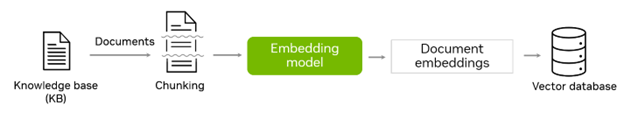

#### b) Generate Embeddings
[Embeddings](https://python.langchain.com/docs/modules/data_connection/text_embedding/) for documents are created by vectorizing the document text; this vectorization captures the semantic meaning of the text. This allows you to quickly and efficiently find other pieces of text that are similar. The embedding model used below is [nvidia/llama-3.2-nemoretriever-300m-embed-v2](https://build.nvidia.com/nvidia/llama-3_2-nemoretriever-300m-embed-v2).
When a user sends their query, the query is also embedded using the same embedding model that was used to embed the documents. This helps find similar or relevant documents to the user's query.

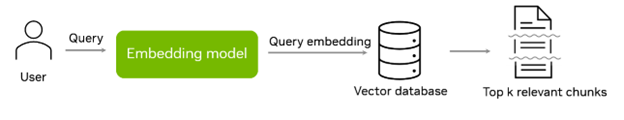

In [5]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings
from langchain.vectorstores import Chroma
import time

# Setup embedding model by NVIDIAEmbeddings
nvidia_embeddings = NVIDIAEmbeddings(
    model="nvidia/llama-3.2-nemoretriever-300m-embed-v2",
    api_key=api_key,
    truncate="NONE"
)

# Create vector store with NVIDIA embeddings
start_time = time.time()
vectorstore = Chroma.from_documents(documents, nvidia_embeddings)
print(f"--- {time.time() - start_time} seconds ---")

/usr/local/lib/python3.12/dist-packages/langchain_nvidia_ai_endpoints/_common.py:234: UserWarning: Found nvidia/llama-3.2-nemoretriever-300m-embed-v2 in available_models, but type is unknown and inference may fail.
  warnings.warn(


--- 8.725878477096558 seconds ---


Note that running the embedding model on an **NVIDIA GPU** (T4) is significantly faster than on a CPU:

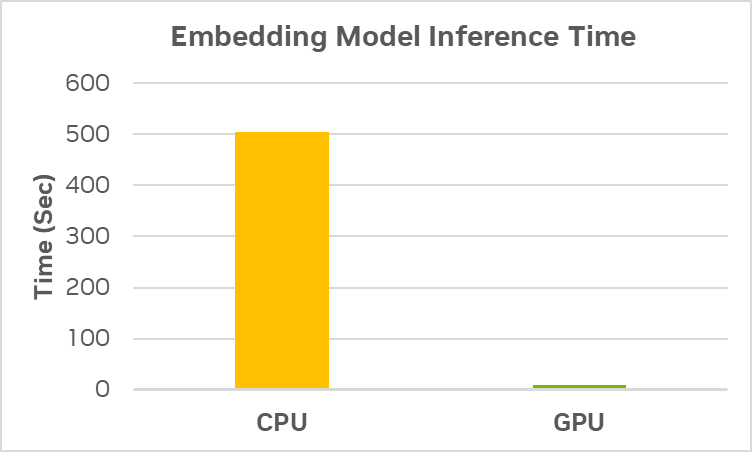

(Note: the benchmark was performed on [intfloat/multilingual-e5-large](https://huggingface.co/intfloat/multilingual-e5-large))

### Part IV: Access NVIDIA AI Foundation Models

Let's explore powerful Large Language Models (LLMs) on NVIDIA AI Foundation Models. Try out the **"[mistralai/mistral-nemotron](https://build.nvidia.com/mistralai/mistral-nemotron)"** model in this example.
The **ChatNVIDIA** is a chat model that connects to NVIDIA AI Foundation Endpoints. The model and its corresponding hyperparameters can be customized. For instance, you can adjust the **temperature** setting to control the randomness of the model's output.

In [6]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

foundation_model="mistralai/mistral-nemotron" # Or use ChatNVIDIA.get_available_models() to get a list of available models.
llm = ChatNVIDIA(model=foundation_model, temperature=0.1, max_completion_tokens=200, top_p=1.0)

### Part V: Ask a question without context

Send request to the LLM without any context from the vector DB. The answer is generic and irrelvant.

In [7]:
from langchain_core.messages import HumanMessage

question = "What is NVQLink?"
result = llm.invoke([HumanMessage(content=question)])
print(result)

content='**NVQLink** is a proprietary software tool developed by **NVIDIA** for **high-performance computing (HPC)** and **AI workloads**. It is designed to optimize **multi-GPU communication** and **data transfer** within a single system or across multiple nodes in a cluster.\n\n### **Key Features of NVQLink:**\n1. **High-Speed GPU-to-GPU Communication**\n   - Enables fast data transfer between NVIDIA GPUs (e.g., Tesla, A100, H100) using **PCIe Gen4/Gen5** or **NVIDIA NVLink** interconnects.\n   - Reduces latency and improves scalability for multi-GPU workloads.\n\n2. **Support for Multi-Node Clusters**\n   - Works with **NVIDIA InfiniBand (IB)** or **Ethernet (RDMA)** for low-latency communication between nodes.\n   - Optimized for **MPI (Message Passing' additional_kwargs={} response_metadata={'role': 'assistant', 'reasoning_content': None, 'content': '**NVQLink** is a proprietary software tool developed by **NVIDIA** for **high-performance computing (HPC)** and **AI workloads**. It

### Part VI: Compose a streamed answer using a Chain
NVIDIA integrated [**TensorRT-LLM**](https://developer.nvidia.com/blog/nvidia-tensorrt-llm-supercharges-large-language-model-inference-on-nvidia-h100-gpus/) into [LangChain chain](https://python.langchain.com/docs/modules/chains/), handling document loading, transformation, embedding generation, and storage.



To complete the pipeline, we use a [RetrievalQA chain](https://js.langchain.com/docs/modules/chains/popular/vector_db_qa/), which is a chain type for question-answering against a vector index. It combines using a *Retrieval* and *question-answering (QA) chain*.

Note that [**TensorRT-LLM**](https://developer.nvidia.com/blog/nvidia-tensorrt-llm-supercharges-large-language-model-inference-on-nvidia-h100-gpus/) significantly boosts the inference efficiency for the foundation model:

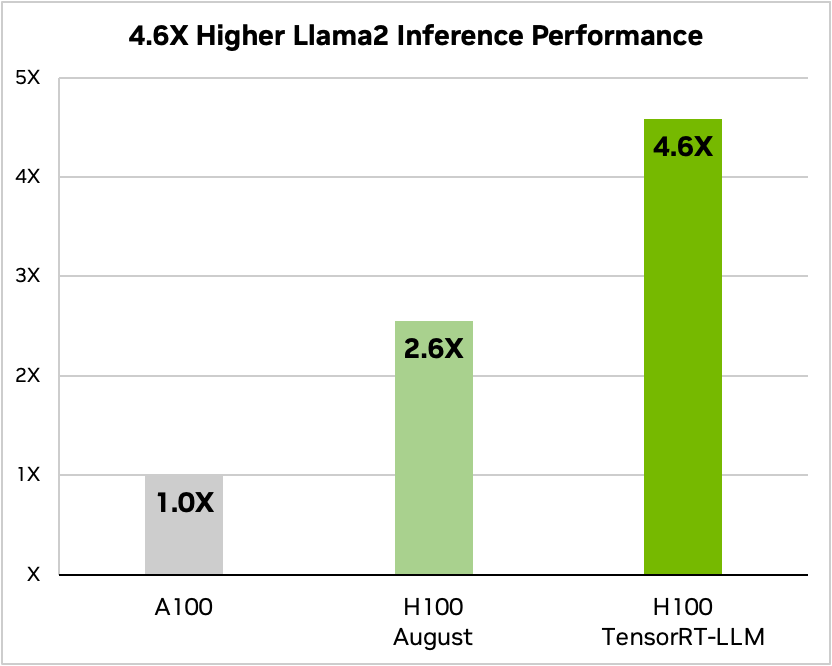

Lastly, we pass a user query to the chain and stream the result.

In [8]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectorstore.as_retriever()
)

result = qa_chain.invoke({"query": question})
print(result['result'])

NVQLink is an architecture proposed for connecting high-performance computing (HPC) resources to the control system of a quantum processing unit (QPU). It aims to accelerate workloads necessary for the operation of the QPU and supports various physical modalities of QPUs and types of quantum system controllers (QSCs). The architecture is designed to optimize real-time processing with latency tolerances of tens of microseconds and uses commercially available Ethernet for the network connection between the HPC and QSC. NVQLink also extends the CUDA-Q programming model to support real-time callbacks and data marshaling, allowing programmers to address CPU, GPU, and FPGA subsystems in the QSC within the same C++ program.
